In [1]:
import pandas as pd
from pathlib import Path
from cmi_dss_lib.utils.metrics import event_detection_ap

from cmi_dss_lib.utils.post_process import post_process_for_seg
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use("ggplot")

RESULT_DIR = "../../../data/eda/predicted-fold0.npz"

In [2]:
data = np.load(RESULT_DIR)
keys = data["key"]
series_ids = list(set([str(k).split("_")[0] for k in keys]))
preds = data["pred"]
labels = data["label"]

gt_df = pd.read_csv(Path("../../../data/train-series-with-partid") / "train_events.csv")
gt_df = gt_df[gt_df["series_id"].isin(series_ids)].dropna().reset_index(drop=True)
gt_df.head(5)

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [9]:
def plot_random_sample(keys, preds, labels, num_samples=1, num_chunks=5):
    # get series ids
    series_ids = np.array(list(map(lambda x: x.split("_")[0], keys)))
    unique_series_ids = np.unique(series_ids)

    # get random series
    random_series_ids = [unique_series_ids[0]]#np.random.choice(unique_series_ids, num_samples)

    for i, random_series_id in enumerate(random_series_ids):
        # get random series
        series_idx = np.where(series_ids == random_series_id)[0]
        this_series_preds = preds[series_idx].reshape(-1, 3)
        this_series_labels = labels[series_idx].reshape(-1, 3)

        # split series
        this_series_preds = np.split(this_series_preds, num_chunks)
        this_series_labels = np.split(this_series_labels, num_chunks)

        fig, axs = plt.subplots(num_chunks, 1, figsize=(20, 5 * num_chunks))
        if num_chunks == 1:
            axs = [axs]
        for j in range(num_chunks):
            this_series_preds_chunk = this_series_preds[j]
            this_series_labels_chunk = this_series_labels[j]

            # get onset and wakeup idx
            onset_idx = np.nonzero(this_series_labels_chunk[:, 1])[0]*2
            wakeup_idx = np.nonzero(this_series_labels_chunk[:, 2])[0]*2

            axs[j].plot(this_series_preds_chunk[:, 0], label="pred_sleep")
            #axs[j].plot(this_series_preds_chunk[:, 1], label="pred_onset")
            #axs[j].plot(this_series_preds_chunk[:, 2], label="pred_wakeup")
            axs[j].vlines(onset_idx, 0, 1, label="onset", linestyles="dashed", color="C1")
            axs[j].vlines(wakeup_idx, 0, 1, label="wakeup", linestyles="dashed", color="C2")
            axs[j].set_ylim(0, 1)
            axs[j].set_title(f"series_id: {random_series_id} chunk_id: {j}")
            axs[j].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

    plt.tight_layout()

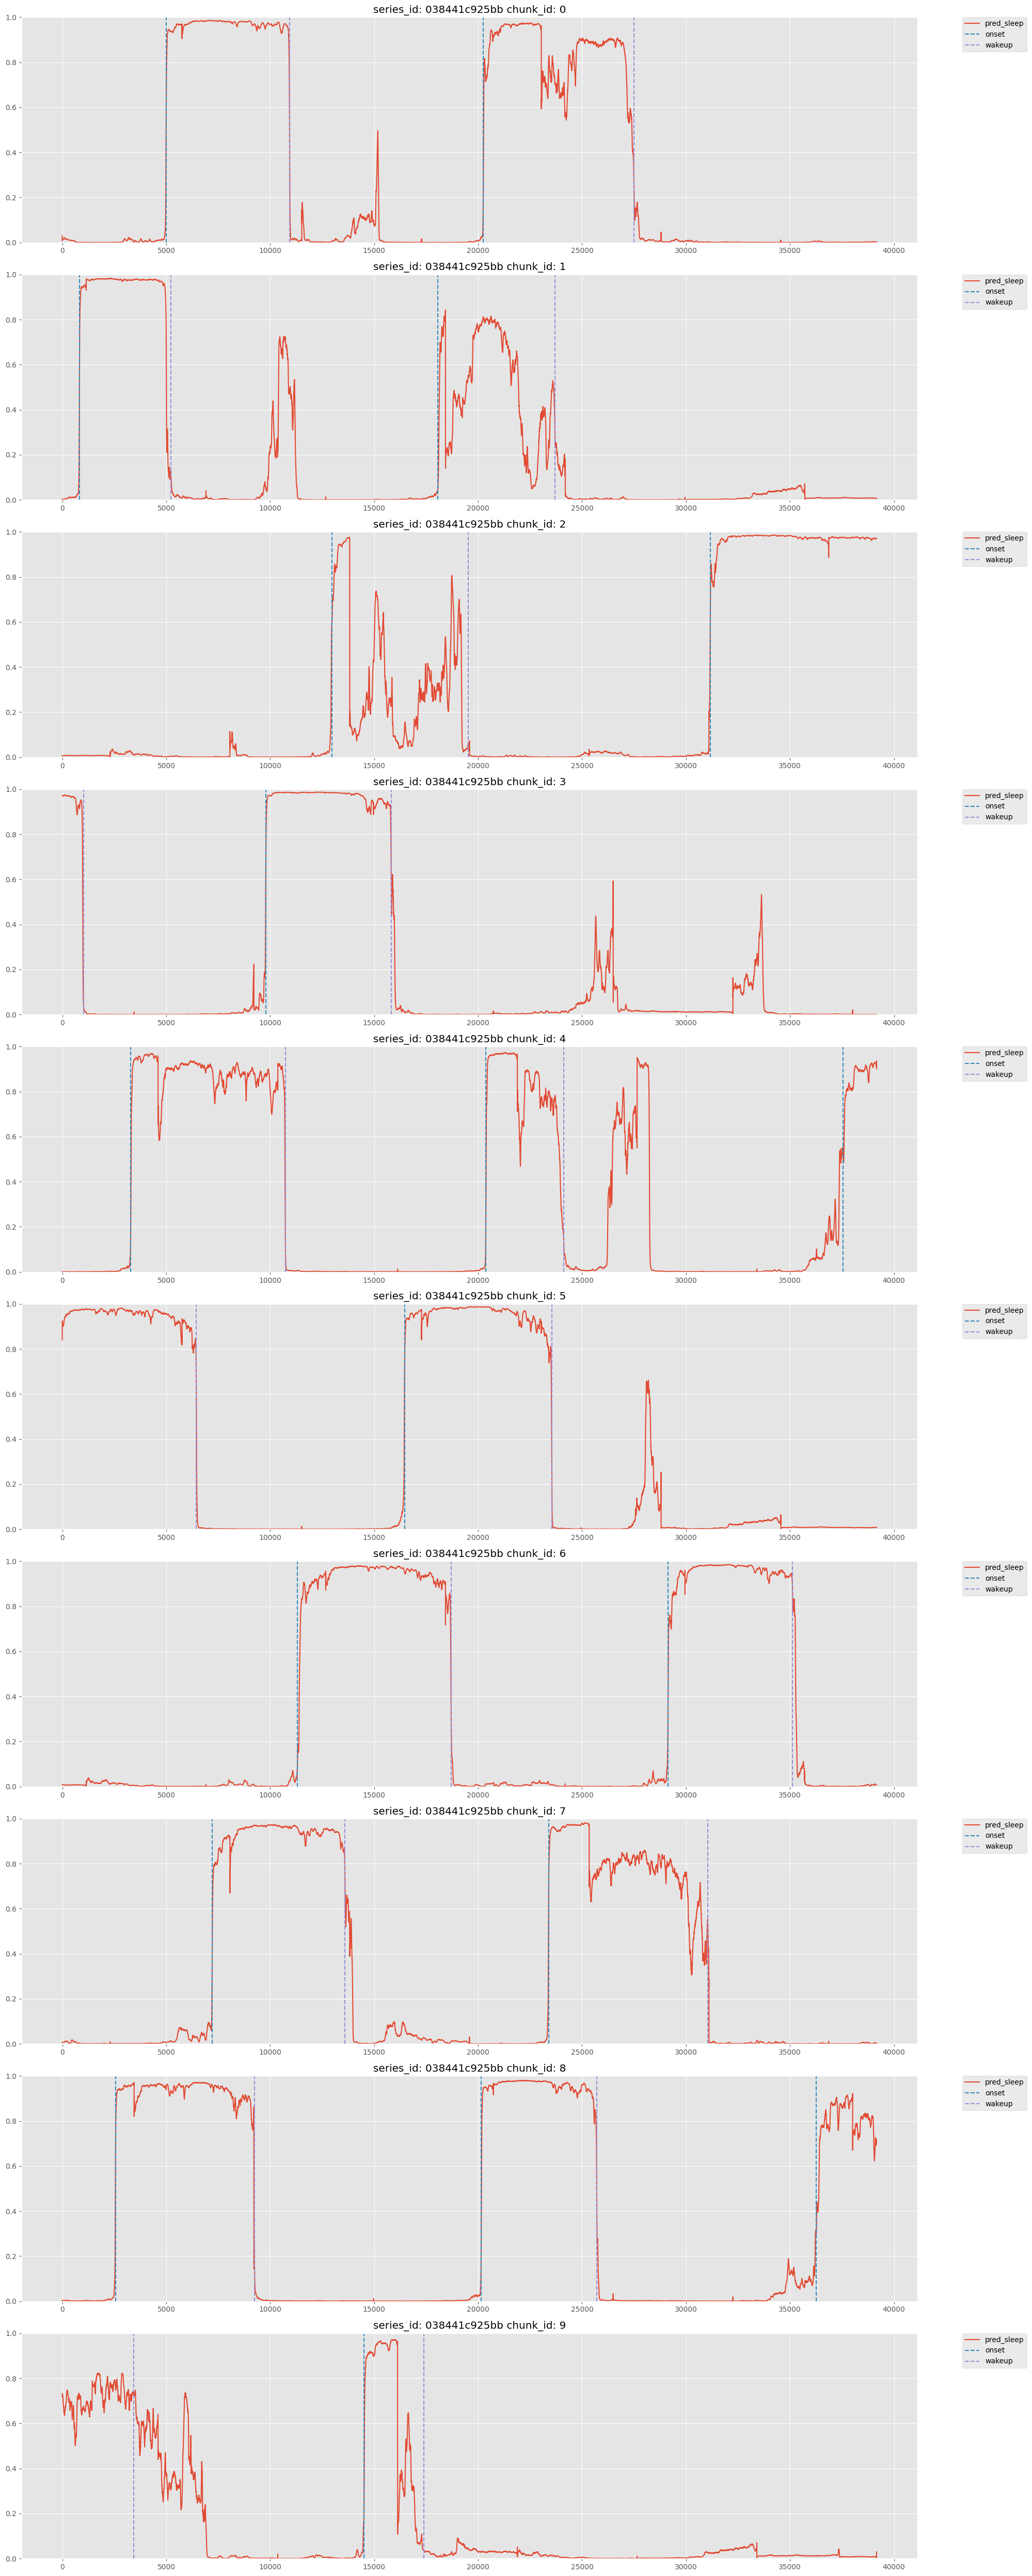

In [10]:
plot_random_sample(keys, preds, labels, num_chunks=10)